# Imports

In [1]:
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
import eval_CT_helper as help

# Recreate dirs

In [2]:
!rm -rf /home/andrew/ITRI-LungCancer/sample_out
!mkdir -p /home/andrew/ITRI-LungCancer/sample_out

In [3]:
path = '/home/andrew/ITRI-LungCancer/sample/'
imgs = os.listdir(path)
imgs.sort()

image_paths = []
labels = []
for i, img in enumerate(imgs):
    # Info for next block
    patient_id = img.split('_')[0]
    slice_location = float(img.split('_')[-1].split('.')[0])
    
    # Get annotations then bboxes
    ann = help.get_ann_from_slice(patient_id, slice_location)
    label = help.ann_to_bbox(ann)
    labels.append(label)
    
    # Save image paths for later
    image_paths.append(path+img)

In [4]:
outpath = '/home/andrew/ITRI-LungCancer/sample_out/'
model = YOLO('/home/andrew/ITRI-LungCancer/YOLO/model_classify_rgb.pt')
preds = []

# Run model on images and save bounding boxes
for i, (path, ann) in enumerate(zip(image_paths, labels)):
    result = model(path, verbose=False, conf=0.3, iou=0.0, augment=True)[0]
    preds.append(help.getBoundingBox(result))

In [5]:
indices = []
preds_filtered = []
labels_filtered = []

for i, (pred, label) in enumerate(zip(preds, labels)):
    # Remove slices that don't have enough contiguous slices
    if help.get_num_relevant_slices(i, preds) < 4:
        pred = []
    if help.get_num_relevant_slices(i, labels) < 4:
        label = []
    
    # Ignore null entries
    if pred == [] and label == []:
        continue
    
    # Add to arrays
    indices.append(i)
    preds_filtered.append(pred)
    labels_filtered.append(label)

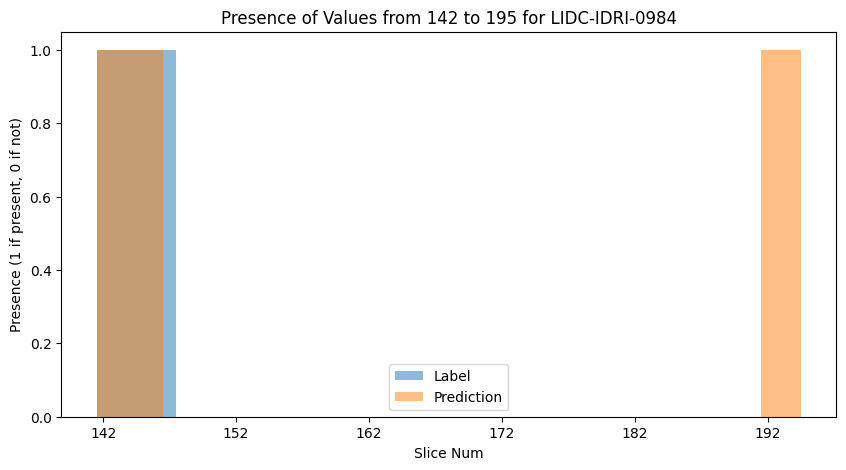

In [6]:
# Determines max y value to show on graph
y_min = indices[0]
y_max = indices[-1]

# Create an array of zeros for the range 0-200
pred_presence = [0] * (y_max-y_min)
label_presence = [0] * (y_max-y_min)

# Mark presence of each value in the list
for i, pred, label in zip(indices, preds_filtered, labels_filtered):
    if pred != []:
        pred_presence[i-y_max] = 1
    if label != []:
        label_presence[i-y_max] = 1

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(y_min, y_max), label_presence, width=1.0, alpha=.5, label='Label')
plt.bar(range(y_min, y_max), pred_presence, width=1.0, alpha=.5, label='Prediction')
plt.xlabel('Slice Num')
plt.ylabel('Presence (1 if present, 0 if not)')
patient_id = path.split('_')[0].split('/')[-1]
plt.title(f'Presence of Values from {y_min} to {y_max} for {patient_id}')
plt.xticks(range(y_min, y_max, 10))
plt.legend()
plt.show()

In [12]:
# Extract noduels from indices
p_nods = help.get_nodules(indices, preds_filtered)
l_nods = help.get_nodules(indices, labels_filtered)

{((142, 146), (435, 253, 11, 11)), ((192, 195), (65, 352, 9, 7))}
{((142, 147), (429, 248, 11, 10))}
